<a href="https://colab.research.google.com/github/NYUExperimentalPhysics1-2021/lab5-magnet-fitter/blob/main/lab_5_magnet_fitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
#@title $\gets$ Run Me First (I have the code setup and function definitions)


import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from bisect import bisect_left, bisect_right
import os, glob
import itertools,operator
from timeit import default_timer as timer
from enum import Enum
import json

gaccel = 9.802

MAJAXIS = 0
MINAXIS = 1
THETA = 2
DPHI = 3
MAGROT = 4
MAGROTRATE =5



class emptystruct:
  pass

def findAngleFiles (startdir):
  #(angleFiles,magFiles) = findSlopeAndAmplitudeFiles(startdir)
  # input stardir: path to directory containing experiments
  # output: list of paths to angle files
  # output slopeFiles: dictionary with paths to slope files, key names are taken from directories under large bob
  #   e.g. if large bob has a directory 2mm, then
  #   slopeFiles["2mm"] is a list of paths to all slope files (end _slope.txt) 
  #   under this directory, even in subdirectories
  # output amplitudeFiles: same as slopeFiles, but paths to all files ending _angle.txt
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python
    #look 1,2, and 3 levels down
    return sorted (glob.glob(startdir + '/**/**/*_angle.txt') + glob.glob(startdir + '/**/*_angle.txt') + glob.glob(startdir + '/**/**/**/*_angle.txt') )
def rreplace(s, old, new, occurrence):
  #replace last instance https://stackoverflow.com/questions/2556108/rreplace-how-to-replace-the-last-occurrence-of-an-expression-in-a-string/59082116#59082116
  li = s.rsplit(old, occurrence)
  return new.join(li)

# needed to check data validity
# returns the indices of the first and last element of the largest sequence of true in a list of booleans
def longestTrueSequence(seq):
  #adapted from https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list
  r = max((list(y) for (x,y) in itertools.groupby((enumerate(seq)),operator.itemgetter(1)) if x), key=len)
  return (r[0][0], r[-1][0])

# Checking data validity (no missed swings, dt reasonable)
# returns longest sequence of valid data
def timeCheck(time,number):
  dt = np.diff(time)
  dn = np.diff(number)%256 #number is mod 256
  maxperiod = 5 #equivalent to 6 meter pendulum
  valid = (dt > 0) & (dt < maxperiod) & (dn==2)
  (start,stop) = longestTrueSequence(valid)
  return (start,stop)
  

def loadAndParseData (angleFilePath, z0=1, energyCalibrationFactor = 1, scale=None, max_rows=450000): #450k readings = 1500s
  magFilePath = rreplace(angleFilePath, 'angle', 'mag',1)
  pulseFilePath = rreplace(angleFilePath, 'angle', 'pulse',1)
  slopeFilePath = rreplace(angleFilePath, 'angle', 'slope',1)
  tcross, theta, majaxis, minaxis, number = np.loadtxt(angleFilePath, skiprows = 1, unpack = True)
  (start,stop) = timeCheck(tcross, number)
  tcross = tcross[start:stop+1]
  theta = theta[start:stop+1]
  majaxis = majaxis[start:stop+1]
  minaxis = minaxis[start:stop+1]
  period = np.mean(np.diff(tcross))

  fixedParams = emptystruct()
  fixedParams.z0 = z0
  fixedParams.L = gaccel*(0.5*period/np.pi)**2

  experiment = emptystruct()
  experiment.anglePath = angleFilePath
  experiment.magPath = magFilePath
  experiment.pulsePath = pulseFilePath
  experiment.period = period
  experiment.skip = 1
  

  xinit = []
  experiment.phi = []
  experiment.b = []
  pulseEnergy = []
  pulsePhase = []

  tmag, magX, magY, magZ = np.loadtxt(magFilePath, skiprows = 1, unpack = True, max_rows=max_rows)
  tpulse, upulse, *_ = np.loadtxt(pulseFilePath, skiprows = 1, unpack = True)
  # tslope,*_ = np.loadtxt(slopeFilePath, skiprows = 1, unpack = True)
  b0 = []

  # tcrossold = tcross

  # for i in range(len(tcross)):
  #   tcross[i] = tslope[np.argmin(abs(tcross[i]-tslope))]
  #plt.plot(tcrossold-tcross)

  if scale is None:
    scale = z0

  for i in range(len(tcross)-1):
    if (majaxis[i]) < 0:
      majaxis[i] = -majaxis[i]
      minaxis[i] = -minaxis[i]
    start = bisect_left(tmag, tcross[i])
    stop = bisect_right(tmag, tcross[i+1])
    if (stop>=len(tmag)):
      break    
    xinit.append((majaxis[i]*scale, minaxis[i]*scale, np.mod(np.deg2rad(theta[i]), 2*np.pi), 0, 0, 0)) #a, b, theta, dphi, tiltrot0, tiltrotrate
    experiment.phi.append(2*np.pi*(tmag[start:stop] - tcross[i]) / (tcross[i+1]-tcross[i]) )
    experiment.b.append((magX[start:stop], magY[start:stop], magZ[start:stop]))
    b0.append(np.sign(magZ[start])*np.max(np.sqrt(magZ[start:stop]**2 + magX[start:stop]**2 + magY[start:stop]**2)))
    start = bisect_left(tpulse, tcross[i])
    stop = bisect_right(tpulse, tcross[i+1])
    if (stop <= start):
      pulseEnergy.append(0)
      pulsePhase.append(-1e-6)
    else:   
      ppulse = np.mod((2*np.pi*(tpulse[start:stop] - tcross[i]) / (tcross[i+1]-tcross[i]) ), np.pi)
      pulseEnergy.append(energyCalibrationFactor*1e-6*np.sum(upulse[start:stop])) #sum all pulses and convert from uJ to J
      pulsePhase.append(np.mean(ppulse)) #average pulse phase mod pi

  experiment.tcross = tcross[0:len(experiment.phi)]
  experiment.pulseEnergy = np.array(pulseEnergy)
  experiment.pulsePhase = np.array(pulsePhase)
  fixedParams.B0 = np.mean(b0)
  experiment.fixedParams = fixedParams
  experiment.offsetInit = (0.0,0.0)
  experiment.tiltAngleInit = 0.0
  experiment.orbitParametersInit = np.array(xinit)

  experiment.orbitParameters = np.copy(experiment.orbitParametersInit)
  experiment.offset = (0.0,0.0)
  experiment.tiltAngle = 0.0

  experiment.axisWeight = [1.0,1.0,1.0]

  alignTheta(experiment)
  calculateB0(experiment)

  plt.figure()

  experiment.fitCompleted = False

  return experiment

def calculateB0(experiment):
  result = scipy.optimize.minimize(lambda x : bscaleObjective(x, experiment), 1, bounds=[(0.1, 10)],options={"maxiter":1000,"disp":False})
  experiment.fixedParams.B0 = experiment.fixedParams.B0*result.x[0]

def bscaleObjective(x, experiment):
  sqerr = 0
  for i in range(len(experiment.phi)):
    bf = bfieldOneOrbit([],experiment,i,[])*x
    deltabs = (bf - np.asarray(experiment.b[i])[:,::experiment.skip])**2
    for j in range(3):
      sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr

def rmsError(experiment):
  skip = experiment.skip
  experiment.skip = 1
  sqerr = bscaleObjective(1,experiment)
  nelem = 0
  for p in experiment.phi:
    nelem = nelem + len(p)
  experiment.skip = skip
  return np.sqrt(sqerr/(3*nelem))

#predicted b, measured b, measured - predicted, sum square error
def bfieldAndResidualFromExperiment(experiment, ind, initial=False):
  if initial:
    orbit = experiment.orbitParametersInit[ind,:]
    bfield = bfieldOneOrbit(orbit, experiment, ind, np.arange(6))
  else:
    bfield = bfieldOneOrbit([], experiment, ind, [])
  be = np.asarray(experiment.b[ind])[:,::experiment.skip]
  res =  be - bfield
  resnorm = np.sum(res**2)
  return (bfield, be, res, resnorm)

def alignTheta(experiment):
  for i in range(len(experiment.phi)):
    b = experiment.b[i]
    ip = np.copy(experiment.orbitParametersInit[i,:])
    bi1 = bfieldOneOrbit(ip, experiment, i, np.arange(6))
    ip[THETA] = np.mod(ip[THETA]+np.pi, 2*np.pi)
    bi2 = bfieldOneOrbit(ip, experiment, i, np.arange(6))
    if (np.sum((bi2-b)**2) < np.sum((bi1-b)**2)):
      experiment.orbitParametersInit[i,THETA] = ip[THETA]

    theta = experiment.orbitParameters[i,THETA]
    b1 = bfieldOneOrbit(theta, experiment, i, THETA)
    b2 = bfieldOneOrbit(theta + np.pi, experiment, i, THETA)
    if (np.sum((b2-b)**2) < np.sum((b1-b)**2)):
      experiment.orbitParameters[i,THETA] = np.mod(theta + np.pi, 2*np.pi)


def dipole_bfield(b0,x,y,dz, z0, tx, ty):
  #field at 0,0,0 if magnet is located at x,y,dz + z0, and tilted from z direction by tx and ty, assuming tx and ty are small 
  #b0 is z-field when magnet is at 0,0,z0 and tx,ty = 0
  #b = u0/4pi r^5 |m|(3 r*(r dot mhat) - r^2 mhat) (wiki magnetic dipole)

  x = x/z0
  y = y/z0
  z = (1 + dz/z0)
  rs = x**2 + y**2 + z**2
  r5 = np.power(rs,2.5)
  mhatz = (1-0.5*tx**2-0.5*ty**2)
  mdotr = -x*tx - y*ty - z*mhatz
  return b0/(2*r5)*(-3*x*mdotr - tx*rs, -3*y*mdotr - ty*rs, -3*z*mdotr - rs*mhatz)

def ellipticalOrbit(phi,a,b,theta,L):
  u = a*np.sin(phi)
  v = -b*np.cos(phi)
  x = u*np.cos(theta) - v*np.sin(theta)
  y = u*np.sin(theta) + v*np.cos(theta)
  dz = L - np.sqrt(L**2 - u**2 - v**2)
  tx = -x/L
  ty = -y/L
  return(x,y,dz,tx,ty)

def ellipticalMagField(phi, a, b, theta, tiltRot0, tiltRotRate, dphi, offset, tiltAngle, fixedParams):
  mp = np.mean(phi)
  tiltx = tiltAngle*np.cos(tiltRot0 + tiltRotRate*(phi-mp))
  tilty = tiltAngle*np.sin(tiltRot0 + tiltRotRate*(phi-mp))
  (x,y,dz,tx,ty) = ellipticalOrbit(phi + dphi,a,b,theta, fixedParams.L)
  return dipole_bfield(fixedParams.B0, x + offset[0], y + offset[1], dz, fixedParams.z0, tx + tiltx, ty + tilty)


def extractGlobalParametersFromVec(x):
  return (x[3:], x[0:2], x[2])

def getParametersFromVec(x,nparams=6,offset=None,tiltAngle=None):
  if (offset is None):
    (x, offset, tiltAngle) = extractGlobalParametersFromVec(x)
  if nparams > 0:
    orbit = np.reshape(x,(-1,nparams))
  else:
    orbit = []
  return(offset, tiltAngle, orbit)
 
def getParametersFromOrbit(orbit):
  #a, b, theta, dphi, tiltrot0, tiltrotrate
  orbit = np.atleast_2d(orbit)
  a = orbit[:,0]
  b = orbit[:,1]
  theta = orbit[:,2]
  dphi = orbit[:,3]
  if np.shape(orbit)[1] >= 5:
    tiltRot0 = orbit[:,4]
  else:
    tiltRot0 = 0.0*a
  if np.shape(orbit)[1] >= 6:
    tiltRotRate = orbit[:,5]
  else:
    tiltRotRate = 0.0*a
  return (a, b ,theta, dphi, tiltRot0, tiltRotRate)

def getVectorFromParameters(offset, tiltAngle, orbit):
  gv = np.full(3,tiltAngle, 'float64')
  gv[0:2] = offset
  return np.concatenate((gv,np.ravel(orbit)))


def bfieldFromParamVecAndExperiment(x, experiment,inds,paraminds,offset=None,tiltAngle=None,fitspin=False):
  if inds is None:
    inds = np.arange(len(experiment.phi))
  if paraminds is None:
    paraminds = np.arange(6)
  
  (offset, tiltAngle, orbitParams) = getParametersFromVec(x,len(paraminds),offset,tiltAngle)
  orbit = experiment.orbitParameters[inds,:]
  orbit[:,paraminds] = orbitParams
  (a, b ,theta, dphi, tiltRot0, tiltRotRate) = getParametersFromOrbit(orbit)
  bfield = []
  for i in range(len(a)):
    #ellipticalMagField(phi, a, b, theta, tiltRot0, tiltRotRate, dphi, offset, tiltAngle, fixedParams):
    bfield.append(ellipticalMagField(np.asarray(experiment.phi[inds[i]])[0::experiment.skip], a[i], b[i], theta[i], tiltRot0[i], tiltRotRate[i], dphi[i], offset, tiltAngle, experiment.fixedParams))
  return bfield



def bfieldOneOrbit(orbitParams, experiment, index, paraminds):
  orbit = np.copy(experiment.orbitParameters[index,:])
  orbit[paraminds] = orbitParams
  (a, b ,theta, dphi, tiltRot0, tiltRotRate) = getParametersFromOrbit(orbit)
  return ellipticalMagField(np.asarray(experiment.phi[index])[0::experiment.skip], a, b, theta, tiltRot0, tiltRotRate, dphi, experiment.offset, experiment.tiltAngle, experiment.fixedParams)

def bfieldOneOrbitTiltAdj(experiment, index, tiltAngle, tiltRotation, tiltRotRate):
  (a, b ,theta, dphi, *_) = getParametersFromOrbit(experiment.orbitParameters[index,:])
  return ellipticalMagField(np.asarray(experiment.phi[index])[0::experiment.skip], a, b, theta, tiltRotation, tiltRotRate, dphi, experiment.offset, tiltAngle, experiment.fixedParams)


def fitterObjectiveTiltOrbit(x, experiment, index):
  tiltAngle = x[0]
  tiltRotation = x[1]
  if (len(x)>=3):
    tiltRotRate = x[2]
  else:
    tiltRotRate = 0
  
  bfield = bfieldOneOrbitTiltAdj(experiment, index, tiltAngle, tiltRotation, tiltRotRate)
  deltabs = (bfield - np.asarray(experiment.b[index])[:,::experiment.skip])**2
  sqerr = 0
  for j in range(3):
    sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr



def fitterObjectiveOrbit(x,experiment,index, paraminds):
  bfield = bfieldOneOrbit(x, experiment, index, paraminds)
  deltabs = (bfield - np.asarray(experiment.b[index])[:,::experiment.skip])**2
  sqerr = 0
  for j in range(3):
    sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr

def fitterObjectiveFunction (x, experiment, inds, paraminds):
  bfield = bfieldFromParamVecAndExperiment (x, experiment, inds, paraminds)
  sqerr = 0
  for i in range(len(bfield)): 
    deltabs = (bfield[i] - np.asarray(experiment.b[inds[i]])[:,::experiment.skip])**2
    for j in range(3):
      sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr



def getBounds(xinit, paraminds):
  
  offsetmin = (-0.01,-0.01)
  offsetmax = (0.01,0.01)
  tiltAngleMin = 0
  tiltAngleMax = np.deg2rad(10)

  (offset, tilt, orbit) = getParametersFromVec(xinit,len(paraminds))

  upper = (0.3, 0.1, 2*np.pi+0.1, 0.1, 2*np.pi+0.1, 2)
  lower = (0, -0.1, -0.1, -0.1, -0.1, -2)
  if np.size(orbit) == 0:
    minp = []
    maxp = [] 
  else:
    maxp = orbit*0.0
    minp = orbit*0.0
    for i in range(len(paraminds)):
      maxp[:,i] = upper[paraminds[i]]
      minp[:,i] = lower[paraminds[i]]


  lb = getVectorFromParameters(offsetmin, tiltAngleMin, minp)
  ub = getVectorFromParameters(offsetmax, tiltAngleMax, maxp)
  return np.transpose((lb,ub))

def fitGlobal(experiment, inds=None, paraminds=[]):

  paraminds = np.atleast_1d(paraminds)
  if (np.size(paraminds) == 0):
    paraminds = []
  if inds is None:
    inds = np.arange(len(experiment.phi))
  xinit = getVectorFromParameters(experiment.offset, experiment.tiltAngle, experiment.orbitParameters[np.ix_(inds,paraminds)])
  bounds = getBounds(xinit,paraminds)
  
  result = scipy.optimize.minimize(lambda x : fitterObjectiveFunction(x, experiment, inds, paraminds), xinit, bounds=bounds,options={"maxiter":1000,"disp":False})
  (experiment.offset, experiment.tiltAngle, orbit) = getParametersFromVec(result.x, len(paraminds))
  experiment.orbitParameters[np.ix_(inds,paraminds)] = orbit
  return result


def fitOrbits(experiment, paraminds=np.arange(6), inds=None):

  paraminds = np.atleast_1d(paraminds)
  xinit = getVectorFromParameters((0,0),0, np.zeros(len(paraminds)))
  bounds = getBounds(xinit, paraminds)
  bounds = bounds[3:,:]

  rv = []
  if inds is None:
    inds = range(len(experiment.phi))
  for i in inds:
    xinit = experiment.orbitParameters[i,paraminds]
    result = scipy.optimize.minimize(lambda x : fitterObjectiveOrbit(x,experiment,i,paraminds), xinit, bounds = bounds, options={"maxiter":1000,"disp":False})
    experiment.orbitParameters[i, paraminds] = result.x   
    rv.append(result)
  #a, b, theta, dphi, tiltrot0, tiltrotrate
  experiment.orbitParameters[:,2] = np.mod(experiment.orbitParameters[:,2],2*np.pi)
  experiment.orbitParameters[:,4] = np.mod(experiment.orbitParameters[:,4],2*np.pi)
  
  return rv



def fitExperiment(experiment, fitSpin = True):
  if experiment.fitCompleted:
    return
  plt.figure()
  (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(experiment.orbitParameters)
  plt.plot(experiment.tcross, np.unwrap(theta)*180/np.pi)
  start = timer()
  sk = experiment.skip
  aw = experiment.axisWeight
  experiment.orbitParameters[:,MAGROTRATE] = 0
  experiment.skip = 8
  experiment.axisWeight = (1,1,1)
  experiment.tiltAngle = np.deg2rad(3)
  fitOrbits(experiment, (MAGROT))
  fitGlobal(experiment)

  print("B0 initial: {:2f}".format(experiment.fixedParams.B0))
  calculateB0(experiment)
  print("B0 updated: {:2f}".format(experiment.fixedParams.B0))
  

  fitOrbits(experiment, (THETA, MAGROT))

  fitGlobal(experiment)
  
  print('{:2f} s elapsed; initial fit - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))

  fitOrbits(experiment, (MAJAXIS, MINAXIS, THETA, DPHI))
  fitGlobal(experiment)

  fitOrbits(experiment, (THETA, MAGROT))  

  fitGlobal(experiment)

  calculateB0(experiment)
  print("B0 updated: {:2f}".format(experiment.fixedParams.B0))
  fitOrbits(experiment, (MAJAXIS, MINAXIS, THETA, DPHI))
  fitGlobal(experiment)

  
  
  print('{:2f} s elapsed; refit orbit dimensions - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))

  tilt = experiment.tiltAngle
  for reps in range(10):
    fitOrbits(experiment, (THETA, MAGROT))  
    fitGlobal(experiment)
    dtilt = experiment.tiltAngle-tilt
    if (np.abs(dtilt) < np.deg2rad(0.1)):
      break
    tilt = experiment.tiltAngle
  
  print('{:2f} s elapsed; iterated fitter completed with dtilt = {} - offset = {} ; tilt = {}'.format(timer()-start, dtilt*180/np.pi, experiment.offset*1000, experiment.tiltAngle*180/np.pi))


    

  # experiment.axisWeight = (1,1,1)
  # inds = np.arange(0,len(experiment.phi),np.ceil(len(experiment.phi)/16),dtype=int) #15 evenly spaced
  # paraminds = (THETA, MAGROT)
  # fitGlobal(experiment, inds, paraminds)
  # print('{:2f} s elapsed; fit offset and tilt with orbit adjustments - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))
  (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(experiment.orbitParameters)
  plt.plot(experiment.tcross, np.unwrap(theta)*180/np.pi)

  if fitSpin: 
    fp = (THETA, MAGROT, MAGROTRATE)
  else:
    fp = (THETA,MAGROT)
  for reps in range(10):
    fitOrbits(experiment,fp) 
    fitGlobal(experiment)
    fitOrbits(experiment, (MAJAXIS, MINAXIS, THETA, DPHI))
    fitGlobal(experiment)
    dtilt = experiment.tiltAngle-tilt
    if (np.abs(dtilt) < np.deg2rad(0.05)):
      break
    tilt = experiment.tiltAngle

  fitOrbits(experiment, fp)

  if fitSpin:
    print('{:2f} s elapsed; iterated fitter with spin completed with dtilt = {} - offset = {} ; tilt = {}'.format(timer()-start, dtilt*180/np.pi, experiment.offset*1000, experiment.tiltAngle*180/np.pi))
  else:
    print('{:2f} s elapsed; iterated fitter without spin round 2 completed with dtilt = {} - offset = {} ; tilt = {}'.format(timer()-start, dtilt*180/np.pi, experiment.offset*1000, experiment.tiltAngle*180/np.pi))
  
  # experiment.axisWeight = (1,1,0)
  # fitOrbits(experiment, (THETA, MAGROT, MAGROTRATE))

  # fitGlobal(experiment)
  # fitOrbits(experiment, (THETA, MAGROT, MAGROTRATE))

  # print('{:2f} s elapsed; added in spin - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))
  (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(experiment.orbitParameters)
  plt.plot(experiment.tcross, np.unwrap(theta)*180/np.pi)
  if fitSpin:
    plt.legend(('initial','without spin', 'with spin'))
  else:
    plt.legend(('initial','without spin', 'further fitting'))
  plt.xlabel('time')
  plt.ylabel('maj axis angle')
  experiment.fitCompleted = True

def updateExperiments(startdir, experiments, z0, energyCalibrationFactor, fitSpin):
  plt.rcParams['figure.figsize'] = [8, 5]
  angleFiles = findAngleFiles(startdir)
  for file in angleFiles:
    found = False
    for e in experiments:
      if os.path.normpath(file) == os.path.normpath(e.anglePath):
        found = True
    if not(found):
      print('loading and fitting: {}'.format(file))
      e = loadAndParseData(file, z0, energyCalibrationFactor)
      fitExperiment(e, fitSpin)
      experiments.append(e)
      print('{}/{} experiments fit'.format(len(experiments), len(angleFiles)))
      plt.show()

def plotRotationRateExperiments (experiments, delta = 100):
  plt.rcParams['figure.figsize'] = [12, 8]
  deghr = np.rad2deg(1)*3600
  rotf = -15/deghr*np.sin(np.deg2rad(40.730610))
  
  ratio = []
  rate = []

  for e in experiments:
    (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(e.orbitParameters)
    t = e.tcross
    numpts = int(np.ceil((t[-1]-t[0])/delta))
    inds = np.linspace(0,len(t),numpts, endpoint=False, dtype=int)
    ratio.append(np.diff(np.cumsum(a*b)[inds])/np.diff(inds)*np.pi/((e.fixedParams.L**2) * experiments[0].period))
    rate.append(np.diff(np.unwrap(theta)[inds])/np.diff(t[inds]))

  for i in range(len(ratio)):
    plt.plot(ratio[i]*1e6, rate[i]*1e6, marker='.', linestyle='none')

  slopepred = .75
  ratio_axis = np.linspace(np.min(np.concatenate(ratio)), np.max(np.concatenate(ratio)))

  ratepred =  slopepred*ratio_axis
  plt.plot(1e6*ratio_axis, 1e6*(ratepred+rotf), 'k-', label='predicted')
  plt.ylabel(r'precession rate ($\mu$rad/s)', fontsize=20)
  plt.xlabel(r'$\frac{\pi a b}{L^2 T}$ ($\mu$rad/s)', fontsize=20)  

  p = np.polyfit(np.concatenate(ratio), np.concatenate(rate), 1)
  plt.plot(1e6*ratio_axis,1e6*(ratio_axis*p[0] + p[1]), 'm--', label='fit')
  plt.legend()
  print('slope measured, predicted = {:2f},{:2f}'.format(p[0], slopepred))
  print('intercept measured, predicted = {:2f},{:2f} deg/hr'.format(p[1]*deghr, rotf*deghr))

initialBlockRun = True

## run this block once (after you edit values to match your setup)
First edit the data values to align with your setup

the `experiments = []` line will erase any data you've already loaded, so run this again to start over

In [70]:
try:
  if not(initialBlockRun):
    raise
except:
  print ("you need to run the code block above first!")
else:  
  experiments = []
  setupNumber = 42
  section = 0 # 1 = M, 2 = T AM, 3 = T PM, 4 = W 
  date = "21-Nov-2021" #change to the date of the experiment
  angleOfWall = 9999 #enter the angle of the major axis IN DEGREES according to your setup when the bob is swinging parallel to the wall
  z0 = .054321 #enter the calibration height above magentometer for your experiments in METERS (i.e. if 60 mm, enter .060)
  mass = .550 #bob mass in kg
  energyCalibrationFactor = 1
  fitSpin = False #if fitting spin makes things worse, then set FitSpin to false and rerun
  !git clone https://github.com/NYUExperimentalPhysics1-2021/lab5-individual-data-mgershow data #change to your github user name - do not erase the "data" afterwards
  startdir = '/content/data'

fatal: destination path 'data' already exists and is not an empty directory.


## Run this block everytime you add data to your github repository
1. `!git -C /content/data pull` : load new  data from your github repository 

2. `updateExperiments(startdir, experiments)` : fit any new data to find angles and orbit parameters: 

3. `plotRotationRateExperiments(experiments)` : plot all the results on a graph of precession rate vs. $\frac{\pi a b}{L^2 T}$. From dimensional analysis, we know the precession per period should be proportional to the ratio of the ellipse area to the length of the string squared. 

`plotRotationRateExperiments(experiments)` takes an optional agrument which is how many seconds to average over when computing the precession rate and $\frac{\pi a b}{L^2 T}$. The default is 100

try `plotRotationRateExperiments(experiments,200)` or `plotRotationRateExperiments(experiments,10)`

Already up to date.
loading and fitting: /content/data/phase30/20211121212648/20211121212648_angle.txt
B0 initial: -1314.126912
B0 updated: -1315.832205
2.069122 s elapsed; initial fit - offset = [ 0.58000318 -0.55333993] ; tilt = 3.4651380162655143
B0 updated: -1318.820511
5.219471 s elapsed; refit orbit dimensions - offset = [ 0.09059614 -0.55559576] ; tilt = 3.466963881824248
6.977499 s elapsed; iterated fitter completed with dtilt = 0.07907750335107169 - offset = [-0.49692824 -0.59618741] ; tilt = 3.886036811062945
9.931654 s elapsed; iterated fitter without spin round 2 completed with dtilt = 0.026149099189701215 - offset = [-0.58226786 -0.6403306 ] ; tilt = 3.9564933331632246
1/2 experiments fit


<Figure size 576x360 with 0 Axes>

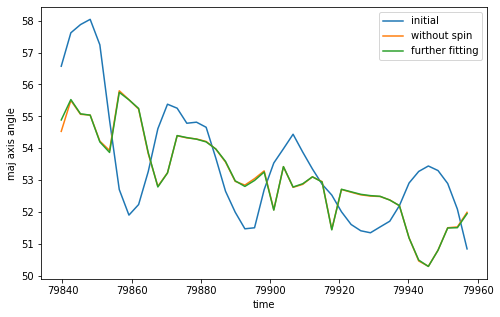

loading and fitting: /content/data/phase60/20211121211923/20211121211923_angle.txt
B0 initial: -1324.897901
B0 updated: -1327.433743
3.348349 s elapsed; initial fit - offset = [-0.3841496 -0.3383312] ; tilt = 4.386871103312742
B0 updated: -1334.041169
11.196747 s elapsed; refit orbit dimensions - offset = [-0.64957708 -0.33091232] ; tilt = 4.47532006019814
12.650684 s elapsed; iterated fitter completed with dtilt = 0.027887663794627596 - offset = [-0.77723078 -0.32576236] ; tilt = 4.503207723992768
16.718331 s elapsed; iterated fitter without spin round 2 completed with dtilt = 0.04317602993147592 - offset = [-0.84404306 -0.32418058] ; tilt = 4.518496090129616
2/2 experiments fit


<Figure size 576x360 with 0 Axes>

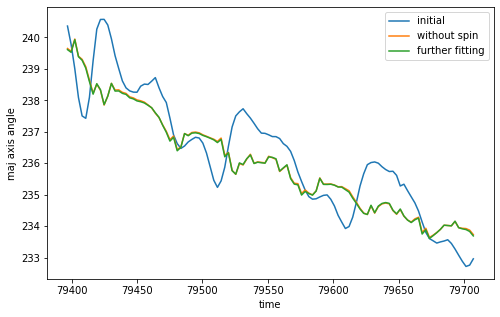

slope measured, predicted = -0.455729,0.750000
intercept measured, predicted = -85.226144,-9.787550 deg/hr
20211121212648_angle.txt: offset = -0.6mm, -0.6mm 	 tilt = 4.0 deg 	 B0 = -1319 uT	 rms error = 55.04 uT
20211121211923_angle.txt: offset = -0.8mm, -0.3mm 	 tilt = 4.5 deg 	 B0 = -1334 uT	 rms error = 71.39 uT


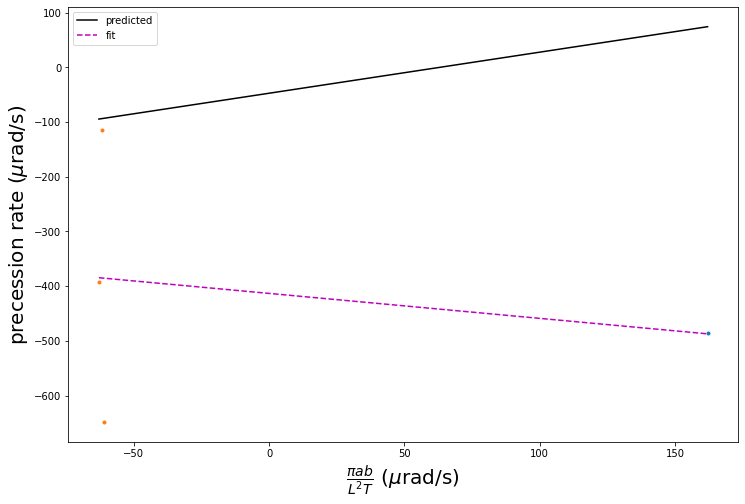

In [71]:
!git -C /content/data pull
updateExperiments(startdir, experiments, z0, energyCalibrationFactor, fitSpin)
plotRotationRateExperiments(experiments)
for e in experiments:
  print('{}: offset = {:.1f}mm, {:.1f}mm \t tilt = {:.1f} deg \t B0 = {:.0f} uT\t rms error = {:.2f} uT'.format(os.path.basename(e.anglePath), 1000*e.offset[0], 1000*e.offset[1], np.rad2deg(e.tiltAngle), e.fixedParams.B0, rmsError(e)))

## Run this block to save your data to a json file
This stores the experimental parameters you entered and the fitting results (but NOT the raw magnetometer data) to a single text file in json format. 

**you should copy this file to your individual github repository AND to the shared class repository**

1. open the file explorer to the left, click on the dots next to the file name and download to the local computer
2. copy the file into the local github repository location, then use github desktop to sync OR use the web interface to upload directly
3. use the web interface to upload the same file to the class repository - don't forget to enter a commit message and save. Note that your commit messages will be publicly visible to the world, so don't include your name or any naughty words.



In [ ]:
fits = []
for e in experiments:
  fits.append({"anglePath":e.anglePath, "magPath":e.magPath, "offset":e.offset.tolist(), "tiltAngle":e.tiltAngle, "L":e.fixedParams.L, "B0":e.fixedParams.B0, "t":e.tcross.tolist(), "orbit":e.orbitParameters.tolist(),
               "pulseEnergy":e.pulseEnergy.tolist(), "pulsePhase":(e.pulsePhase + e.orbitParameters[:,DPHI]).tolist()})
results = {"setupNumber":setupNumber, "section":section, "thetaWall":np.deg2rad(angleOfWall), "z0":z0, "mass":mass, "energyCalibrationApplied":energyCalibrationFactor, "fits":fits}
outputname = 'section{:d}setup{:d}-{}.json'.format(int(section), int(setupNumber), date)
file = open(outputname, 'w')
json.dump(results, file)
file.close()

print('data saved in {} - BE SURE TO COPY TO YOUR GITHUB'.format(outputname))